# Code Generation with Dynamic Shape
**Large Language Models are dynamic**
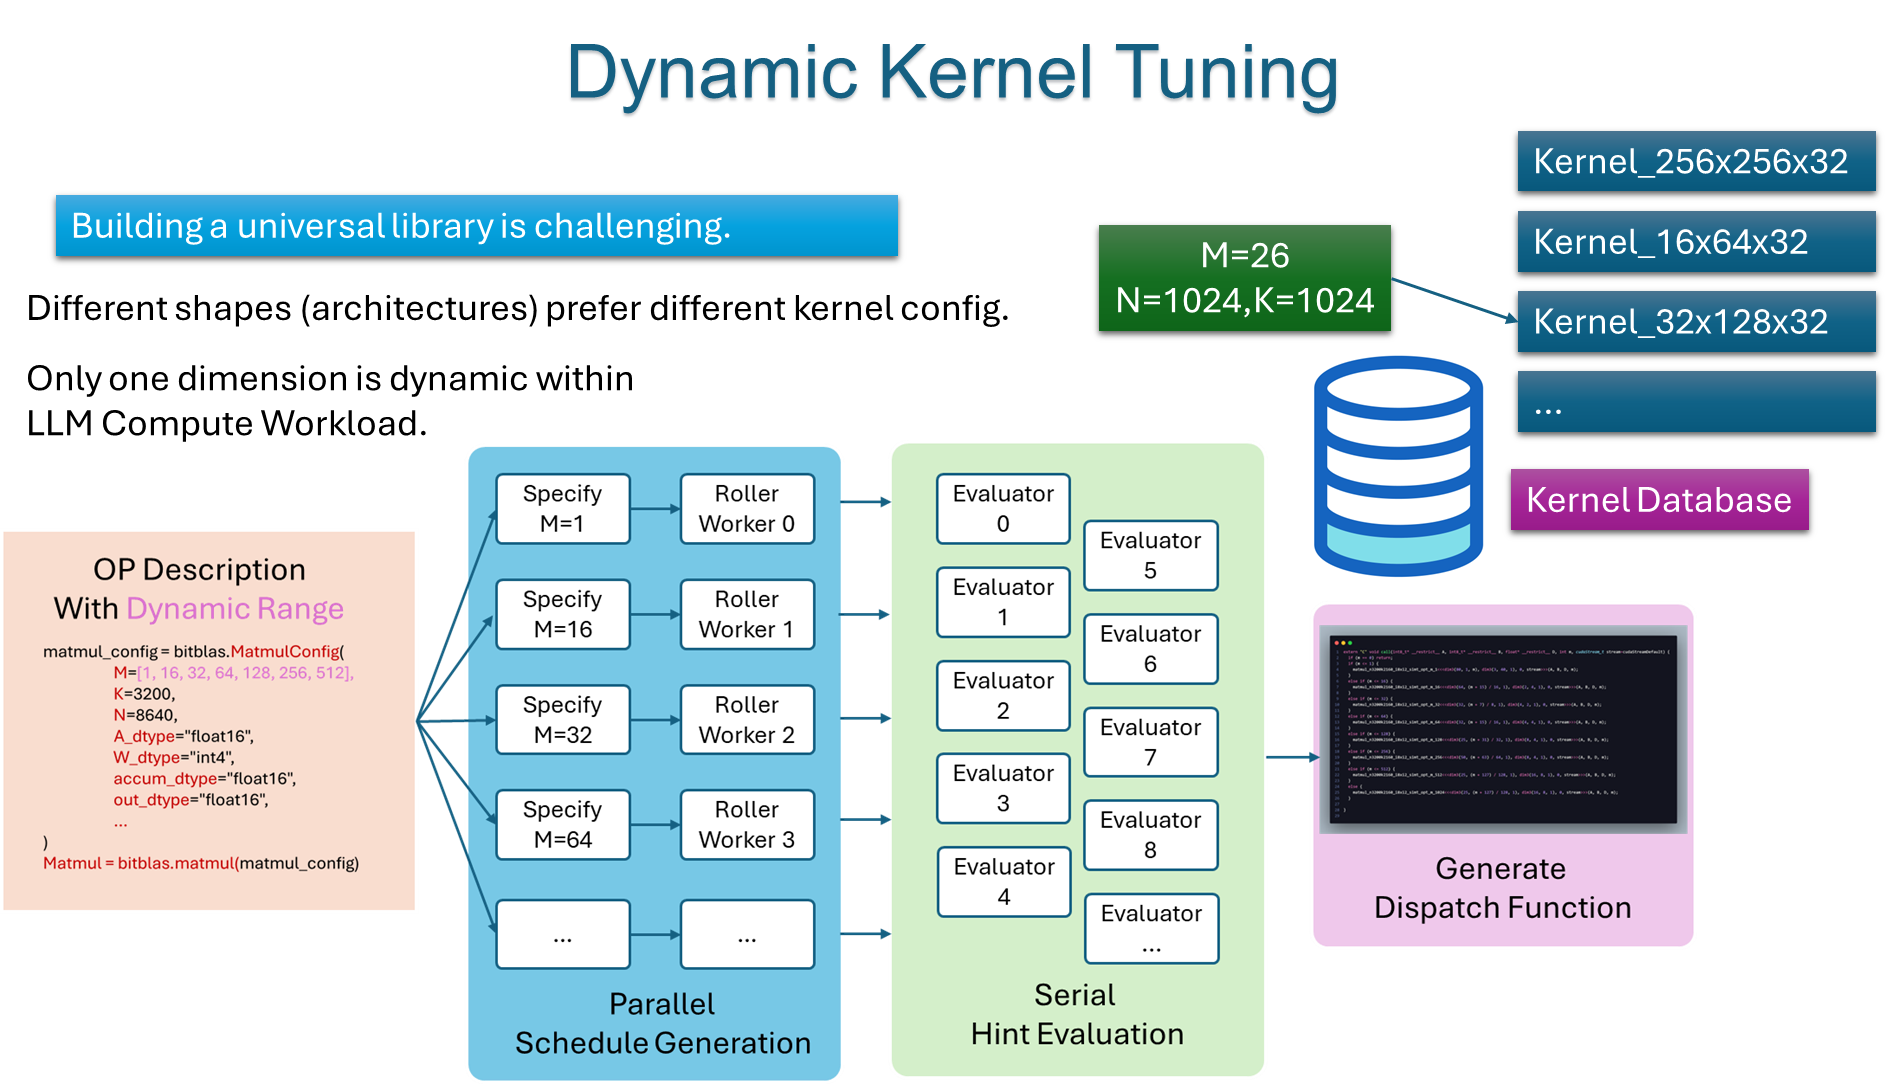

In [ ]:
import bitblas
import torch

# enabling debug output

bitblas.set_log_level("Debug")

In [1]:
matmul_config = bitblas.MatmulConfig(
    M=[1, 16, 32, 64, 128, 256],  # M dimension, default value is from 1 to 1024
    N=1024,  # N dimension
    K=1024,  # K dimension
    A_dtype="float16",  # activation A dtype
    W_dtype="int4",  # weight W dtype
)

matmul = bitblas.Matmul(config=matmul_config, enable_tuning=False)
print(matmul.get_source())

2024-10-25 08:25:39 [BitBLAS:INFO]: Auto detected target: nvidia/geforce-rtx-4090

template <typename T1, typename T2, bool isSigned = false>
__device__ void decode_i4b_to_f16(T1 *_i4s, T2 *B_local_decode, const int N = 8)
{
    uint *h = reinterpret_cast<uint *>(B_local_decode);

    static constexpr uint immLut = (0xf0 & 0xcc) | 0xaa;
    static constexpr uint BOTTOM_MASK = 0x000f000f;
    static constexpr uint FP16_TOP_MAGIC_NUM = 0x64006400;
    static constexpr uint MEDIAN_NUM = isSigned ? 0x64086408 : 0x64006400;
    uint const i4s = *reinterpret_cast<uint *>(_i4s);
#pragma unroll
    for (int i = 0; i < (N / 2); i++)
    {

        asm volatile("lop3.b32 %0, %1, %2, %3, %4;\n"
                     : "=r"(h[i])
                     : "r"(i4s >> (4 * i)), "n"(BOTTOM_MASK), "n"(FP16_TOP_MAGIC_NUM), "n"(immLut));
        asm volatile("sub.f16x2 %0, %1, %2;\n" : "=r"(h[i]) : "r"(h[i]), "r"(MEDIAN_NUM));
    }
}

template <typename T1, typename T2>
__device__ void decode_i4s_to_f16(T1

In [3]:
matmul.hardware_aware_finetune(topk=20, parallel_build=True)
print(matmul.get_source())

2024-10-25 08:27:16 [BitBLAS:INFO]: Start fast tuning with dynamic range
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Cannot find the appropriate index map for tensorcore
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Apply config {'block': [2], 'thread': [2], 'rstep': [1024], 'reduce_thread': [64], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Apply config {'block': [1], 'thread': [1], 'rstep': [1024], 'reduce_thread': [128], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Apply config {'block': [4], 'thread': [4], 'rstep': [1024], 'reduce_thread': [32], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Apply config {'block': [8], 'thread': [8], 'rstep': [1024], 'reduce_thread': [16], 'vectorize': {'A': 8, 'B_decode': 8}}
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Apply config {'block': [16], 'thread': [16], 'rstep': [512], 'reduce_thread': [8], 'vectorize': {'A': 4, 'B_decode': 8}}
2024-10-25 08:27:16 [BitBLAS:DEBUG]: Apply con